## Hebbian learning in feedforward networks.

Based on the code below, implement a number of experiments to investigate how Hebbian learning behaves when training neural networks.
To be able to evaluate how successful an approach is, we will be using a subset of the MNIST dataset to train on and evaluate the quality of the learned Hebbian features by using either a "majority-vote" readout or a linear regression to finish the classification problem (see below). Additionally, we can look at the weight vectors as images to get a sense of the quality of the learned, unsupervised features.

Note, that the network we are using is completely linear and has no biases. $y = W x$ where $y$ is the output and $x$ is the input.

Your job will be to implement the training of these features (on batches and for networks!), the rest of the code is provided.

For each of the variants below, discuss the outcomes for each of the evaluation steps. Use a markdown cell at the bottom of the notebook, and compare the results to each other. First, write down the hypothesis for the experiments, then discuss what you have learned.

Here are the variants to compare:

1. a standard hebbian learning rule, for one neuron: $w_i^{n+1} = w_i^{n} + \eta  x_i y$ where $y$ is the non-linear output, $x$ is the input, and $i$ gives the input index. $\eta$ is the learning rate. $n$ is the bacht-step.
2. a standard hebbian learning, but only the neuron with the highest activation (the winner) is allowed to learn.
3. a standard hebbian learning rule + WTA with weight normalization.
4. use Oja's rule instead of a standard hebbian rule.


## Hypothesis

Variant 1: I think the weights trained with normal hebbian will just explode, since there is nothing regulating them down. Additionally, the weights will probably look like the "average" of the images we give it, since we do not constrict learning for the individual neurons they all learn the same things over and over. 


Variant 2: For normal hebb in WTA I am not so sure. Technically there isn't any mechanism to regulate the weights down here either but since only one neuron gets to learn and adapt its weights for one specific input (i.e. the input image that it won) that might be enough to fight off exploding weights. I would expect there to be some problem with high weights, especially for higher epochs since there could be a snowball effect of a neuron being chosen over and over again. For the shape of the weights I would expect some parts of images to come through (e.g. a straight line from a one or a seven, or a rounded shape from a three, five or eight).


Variant 3: I would expect the same as Variant 2 without the snowball problem.

Variant 4: I am actually not sure if we should do Oja's rule with WTA or Oja's rule on its own so I will try both variants. The weights would not explode due to the substraction term. For the weights I would expect again some shapes to come through, but maybe not as much as with WTA + hebb. The reason for that is, that while Oja's rule does induce competition on a weight level (since the weight vector is supposed to be stable and kept at a constant length, when one weight increases others will decrease), there is no competition on a neuron level. I would expect Oja + WTA to have the best formed weights since it combines the best of both worlds: competition on a neuron and a weight level.  

For the classification: I would expect hebb on its own to perform the worst and hebb + WTA + weight normalization and WTA + Oja to perform the best.


In [13]:
from __future__ import annotations

import argparse
import random
from pathlib import Path
from typing import Sequence, Tuple

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from utils import draw_weights

In [14]:
def load_mnist_numpy(root):
    root = Path(root)
    train_ds = datasets.MNIST(root, train=True, download=True)
    test_ds  = datasets.MNIST(root, train=False, download=True)

    def ds_to_numpy(ds):
        images = np.stack([np.array(img, dtype=np.float32).reshape(-1) / 255.0 for img, _ in ds])
        labels = np.fromiter((label for _, label in ds), dtype=np.int32, count=len(ds))
        return images, labels

    Xtr, ytr = ds_to_numpy(train_ds)
    Xte, yte = ds_to_numpy(test_ds)
    return Xtr, ytr, Xte, yte


def make_subset(X: np.ndarray, y: np.ndarray, digits: Sequence[int], fraction: float) -> Tuple[np.ndarray, np.ndarray]:
    mask = np.isin(y, digits)
    idx = np.where(mask)[0]
    rng = np.random.default_rng(0)
    rng.shuffle(idx)
    k = int(len(idx) * fraction)
    idx = idx[:k]
    return X[idx], y[idx]

In [35]:
data_dir = "./data"
digits = [0,1,2,3,4] # we are only going to look at 5 classes for now
fraction_of_dataset = 0.5 # and only for 50% of the images in there


Xtr_all, ytr_all, Xte_all, yte_all = load_mnist_numpy(data_dir) # full dataset
Xtr, ytr = make_subset(Xtr_all, ytr_all, digits, fraction_of_dataset) # subset training
Xte, yte = make_subset(Xte_all, yte_all, digits, fraction_of_dataset) # subset testing

In [125]:
class HebbNet:

    def __init__(self, input_dim: int, n_units: int = 64, rule: str = "oja", norm_weights=False, mode="normal"):
        assert rule in ("oja", "hebb", "BCM"), "rule must be 'oja' or 'hebb' or 'BCM' " 
        assert mode in ("normal", "WTA"), "rule must be 'normal' or 'WTA'"
        self.rule = rule
        self.mode = mode
        self.norm_weights = norm_weights
        self.rng  = np.random.default_rng()
        self.input_dim = input_dim
        self.W    = self.rng.normal(0, 0.1, size=(n_units, input_dim)).astype(np.float32)
        self.W   /= np.linalg.norm(self.W, axis=1, keepdims=True) + 1e-9
        

        # BCM hps
        self.threshold = np.zeros(n_units) # self.rng.normal(0, 0.1, size=(n_units)).astype(np.float32)
        self.gamma = 0.5
        self.tau_th= 0.9
        self.tau_w = 0.3

    # Your job: Forward + learning
    def forward(self, X: np.ndarray) -> np.ndarray:
        # implement the forward pass for the hebbain activations.

        return X @ self.W.T

    def update_weights_batch(self, X: np.ndarray, eta: float):
        # implement the hebbian learning rules (and with winner take all). Do this for a whole batch at a time!
        # you can switch between different rules based on self.rule
        Y = self.forward(X)        
        print(Y.shape)

        if self.mode == "normal":
            # iterate over batch
            for i in range(batch_size):
                    
                # pick corresponding input and output vectors, otherwise dims when x * y wont work out 
                x_vec = X[i,:] 
                y_vec = Y[i,:]

                if self.rule == "hebb":
                     self.W += eta * np.outer(y_vec, x_vec)

                if self.rule == "oja":          
                    y_vec = y_vec.reshape(-1)               
                    delta_w = np.outer(y_vec , ( x_vec - np.dot(y_vec, self.W)))
                    self.W += eta * delta_w

            self.W /= batch_size # after iterating over batch div with batchsize 

            if self.norm_weights:
                self.W /= np.linalg.norm(self.W) + 1e-9

            
        if self.mode == "WTA": 
            # pick winners per input vec (img)
            winners = Y.argmax(axis=1)
            for i, w in enumerate(winners):
                x_vec = X[i]    # pick input that the neuron "won"
                y = Y[i, w]     # pick output (scalar) of winning neuron    

                if self.rule == "hebb": 
                        self.W[w] += eta * y * x_vec 

                if self.rule == "oja":
                    delta_w = y * ( x_vec - y * self.W[w])
                    self.W[w] += eta * delta_w

                if self.rule == "BCM":
                    # calc current threshold 
                    t = np.mean(Y**2, axis=0)[w] # avg of neuron over batch 

                    # update threshold using moving avg 
                    self.threshold[w] = ( self.gamma*self.threshold[w] + (1-self.gamma) * t ) * self.tau_th

                    # calc delta W
                    delta_w = ( (y * ( y - t ) )  * x_vec) / t 
                    delta_w /= X.shape[0] # normalize the weights update according to the number of features 

                    # update weights
                    self.W[w] += delta_w * self.tau_w  

                if self.norm_weights:
                    self.W[w] /= np.linalg.norm(self.W[w]) + 1e-9

    # ----- helpers ------
    
    # Supervised linear read‑out (ridge regression)
    def train_linear_classifier(self, X: np.ndarray, y: np.ndarray, reg: float = 1e-3):
        """Fit `W_out` via linear regression. This is technically a "delta rule".
        """
        A = self.forward(X)                 # (N, H)
        N, H = A.shape
        classes = int(y.max()) + 1
        # One‑hot encode labels → Y (N, C)
        Y = np.zeros((N, classes), dtype=np.float32)
        Y[np.arange(N), y] = 1.0
        # Closed‑form ridge solution
        I = np.eye(H, dtype=np.float32)
        self.W_out = np.linalg.solve(A.T @ A + reg * I, A.T @ Y)  # (H, C), safe in the object

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predicted class indices using the trained linear read‑out."""
        if self.W_out is None:
            raise RuntimeError("Linear classifier not trained. Call train_linear_classifier first.")
        logits = self.forward(X) @ self.W_out  # (B, C)
        return logits.argmax(axis=1)

    def linear_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Accuracy using the supervised read‑out (must be trained)."""
        preds = self.predict(X)
        return float((preds == y).mean())

    # Evaluation with majority votes.
    def majority_labels(self, X: np.ndarray, y: np.ndarray) -> list[int]:
        winners = self.forward(X).argmax(axis=1)
        bag = [[] for _ in range(self.W.shape[0])]
        for w, lbl in zip(winners, y):
            bag[w].append(lbl)
        return [max(set(b), key=b.count) if b else -1 for b in bag]

    def accuracy(self, X: np.ndarray, y: np.ndarray, unit_labels: Sequence[int]) -> float:
        preds = np.take(unit_labels, self.forward(X).argmax(axis=1))
        return float((preds == y).mean())

# Your job: Training loop
def train(net: WTANet, X: np.ndarray, epochs: int, eta: float, batch_size: int):
    # train on batches for multiple epochs. 
    # its a good idea to randomize the order of training per epoch.
    n_samples = X.shape[0]

    for epoch in range(epochs):

        np.random.shuffle(X) # Shuffle the input data

        # Iterate over all minibatches
        for i in range(n_samples // batch_size):
            minibatch = X[i * batch_size:(i + 1) * batch_size]
            net.update_weights_batch(minibatch, eta)
        draw_weights(net.W, epoch=epochs-1)


In [126]:
def plot_weight_vectors(variant, W, cols=8, figsize_ratio=1.2, cmap="gray"):
    n_units, dim = W.shape
    assert dim == 28 * 28, "Weights must be flattened 28×28 images"

    rows = int(np.ceil(n_units / cols))
    plt.figure(figsize=(cols * figsize_ratio, rows * figsize_ratio))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.axis("off")
        if i < n_units:
            plt.imshow(W[i].reshape(28, 28), cmap=cmap)
    plt.tight_layout()
    plt.colorbar()
    plt.suptitle(f"{variant}")
    plt.show()

In [127]:
## Classification part 

#  Evaluate a simple "majory label" approach: 
#  i) Every neuron gets a vote according to the input class it is most active for
# ii) For every input, every neuron votes for that class, majority wins.

def classify(net): 
    unit_lbls = net.majority_labels(Xtr, ytr)
    acc       = net.accuracy(Xte, yte, unit_lbls)

    print(f"Test accuracy (majority vote):     {acc:.3f}")

    # Alternatively, evaluate a simple linear classifier on the features learned by the hebb algorith,.

    net.train_linear_classifier(Xtr, ytr)
    acc_lc = net.linear_accuracy(Xte, yte)

    print(f"Test accuracy (linear classifier): {acc_lc:.3f}")

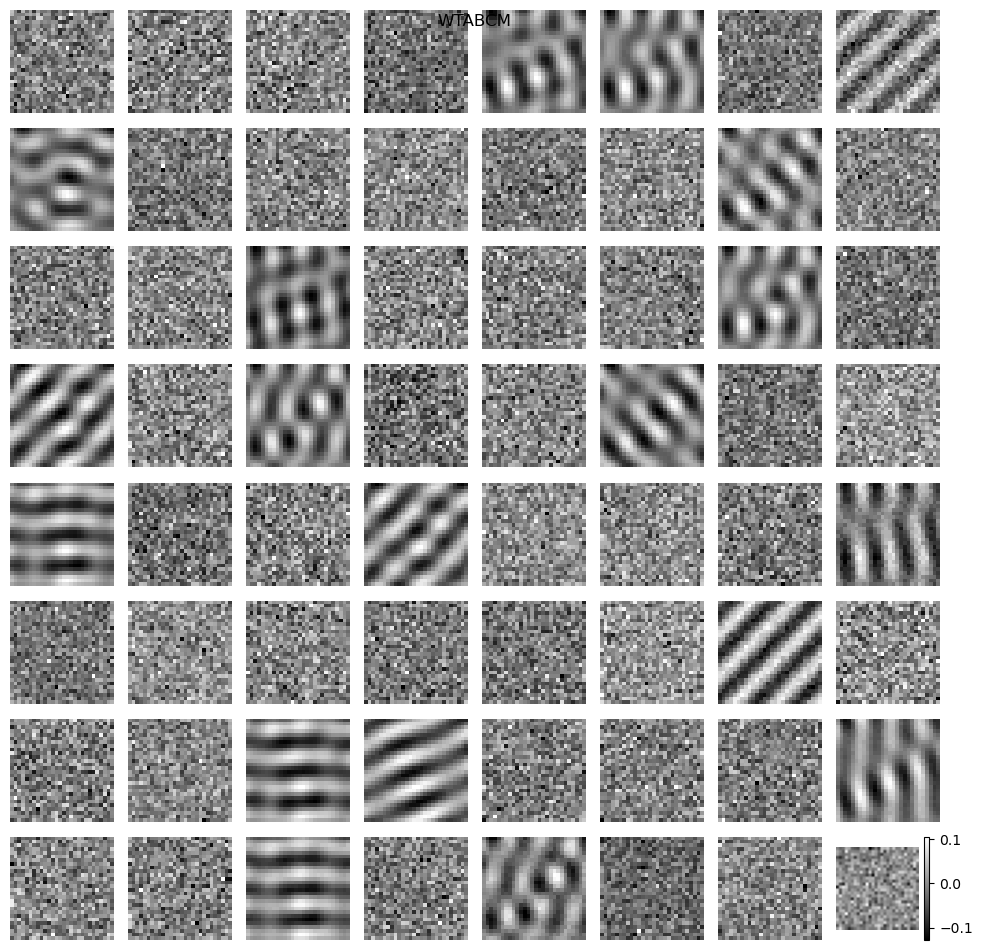

In [128]:

hidden_units = 64
mode = "WTA"
rule = "BCM" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 5
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
WTABCM = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(WTABCM, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("WTABCM", WTABCM.W)

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])


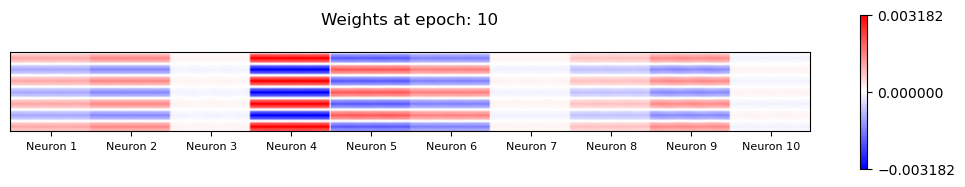

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
#import utils 
from utils import draw_weights, selectivity_metric
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape


print(data.shape)
n_samples, n_in = data.shape
mode = "normal"
rule = "oja" # "hebb" and "oja", are your options here
Xtr = data#.T

# hps #
n_epochs = 10

#n_epochs = 10
n_units = hidden_units = 10
batch_size = 100
#tau_th = 0.09
tau_th = 0.1
tau_w = 0.001
epochs = 10
eta = 0.05 # learning rate
batch_size = 100 # batch size
norm_weights = False 


hebb_norm = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(hebb_norm, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)


(100, 10)
(100, 10)
(100, 10)
(100, 10)


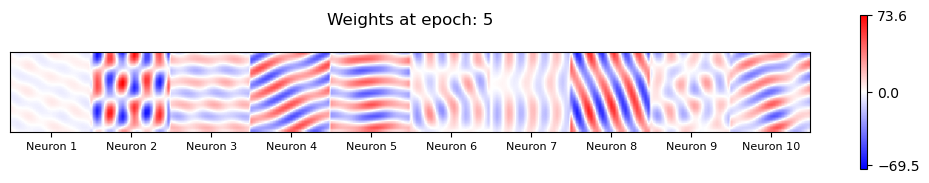

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
#import utils 
from utils import draw_weights, selectivity_metric
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
#data = torch.from_numpy(data_np)
data = data_np
n_samples, n_in = data.shape


print(data.shape)
n_samples, n_in = data.shape
mode = "WTA"
rule = "BCM" # "hebb" and "oja", are your options here
Xtr = data#.T


#n_epochs = 10
n_units = hidden_units = 10
batch_size = 100
#tau_th = 0.09

epochs = n_epochs = 5
eta = 0.05 # learning rate
batch_size = 100 # batch size
norm_weights = False 


hebb_norm = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(hebb_norm, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)


(128, 64)
(128, 64)
(128, 64)


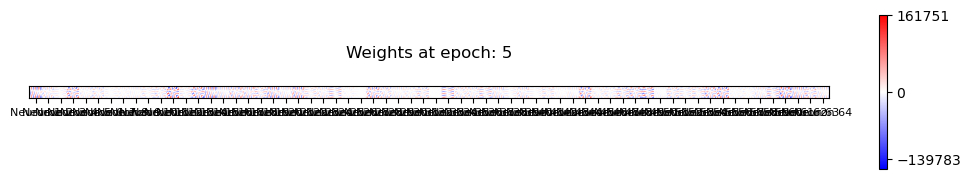

In [131]:
### Variant 1.1: normal hebbian learning (+ weight norm)

hidden_units = 64
mode = "normal"
rule = "hebb" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 5
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
hebb_only = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(hebb_only, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

#plot_weight_vectors("normal hebb", hebb_only.W)

In [132]:
hebb_only.W

array([[-2.33501185e-34, -3.87846172e+04, -5.59577695e+04, ...,
        -7.72177031e+04, -1.00368039e+05, -7.19646875e+04],
       [ 1.53720388e-33, -1.58989365e+04, -2.40671855e+04, ...,
        -3.87518555e+04, -4.62230469e+04, -3.52118047e+04],
       [ 3.18533549e-33, -5.13002881e+03, -8.65784668e+03, ...,
        -1.56272021e+04, -1.58675059e+04, -1.32706846e+04],
       ...,
       [ 2.48947864e-35, -2.52074102e+04, -3.56247773e+04, ...,
        -4.16735898e+04, -5.56913047e+04, -3.72088984e+04],
       [ 5.49407371e-34,  1.94291738e+04,  3.10452441e+04, ...,
         5.62382773e+04,  6.31276953e+04,  5.11237500e+04],
       [ 1.33375483e-33, -1.01184795e+04, -1.40101621e+04, ...,
        -2.16495000e+04, -3.01055586e+04, -2.18541055e+04]], dtype=float32)

In [133]:
classify(hebb_only)

Test accuracy (majority vote):     0.039


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (400,) (15298,) 

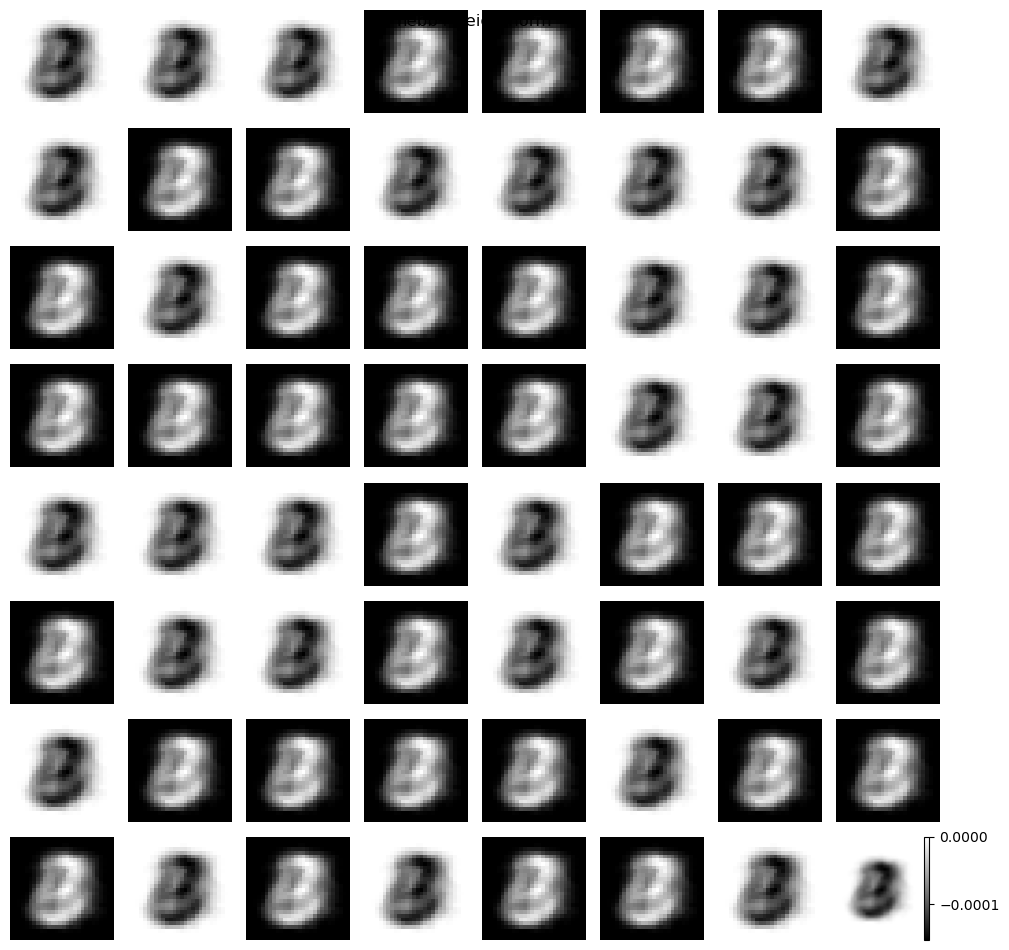

In [ ]:
### Variant 1.2: normal hebbian learning (+ weight norm)

hidden_units = 64
mode = "normal"
rule = "hebb" # "hebb" and "oja", are your options here
norm_weights = True 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
hebb_norm = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(hebb_norm, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("hebb+weightnorm", hebb_norm.W)

In [ ]:
classify(hebb_norm)

Test accuracy (majority vote):     0.221
Test accuracy (linear classifier): 0.221


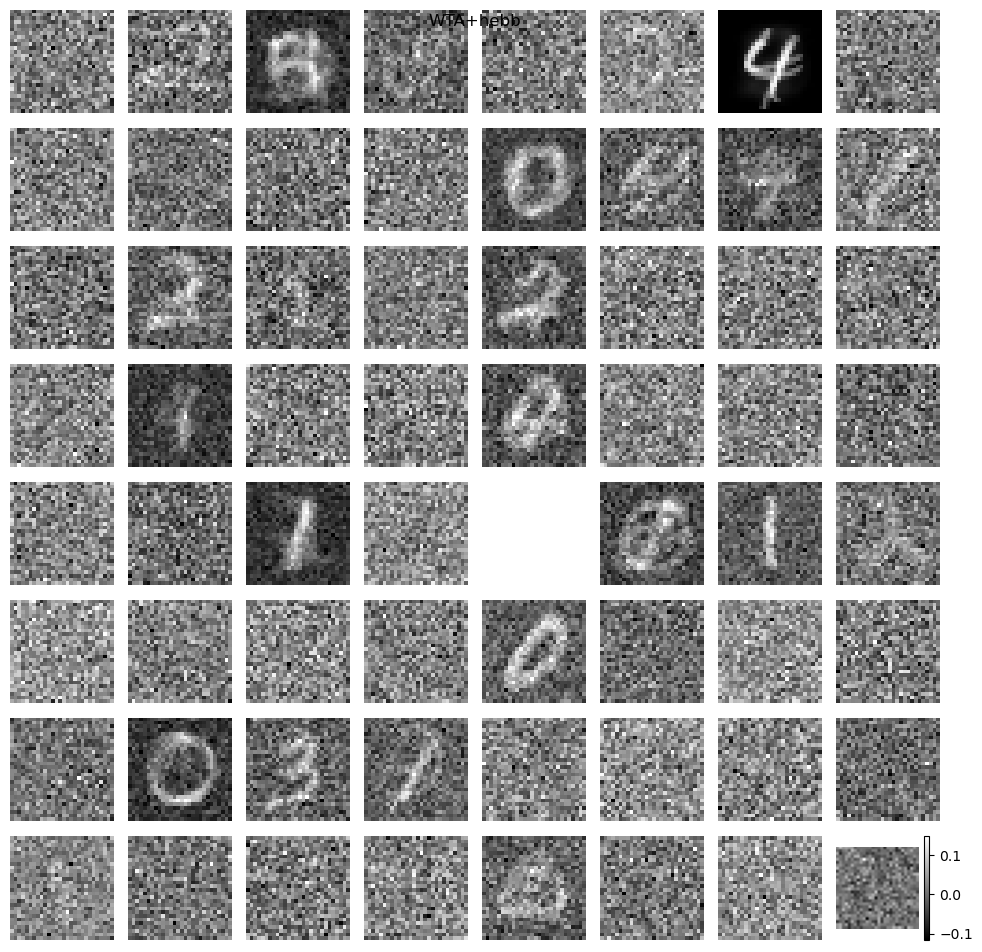

In [ ]:
### Variant 2: WTA + normal hebbian learning 

hidden_units = 64
mode = "WTA"
rule = "hebb" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
WTAhebb = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(WTAhebb, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("WTA+hebb",WTAhebb.W)

In [ ]:
classify(WTAhebb)

Test accuracy (majority vote):     0.221
Test accuracy (linear classifier): 0.193


In [ ]:
### Variant 3: WTA + normal hebbian learning + weight normalization

hidden_units = 64
mode = "WTA"
rule = "hebb" # "hebb" and "oja", are your options here
norm_weights = True 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
wta_hebb_norm = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(wta_hebb_norm, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("WTA+hebb+weightnorm",wta_hebb_norm.W)

KeyboardInterrupt: 

In [ ]:
classify(wta_hebb_norm)

Test accuracy (majority vote):     0.267
Test accuracy (linear classifier): 0.307


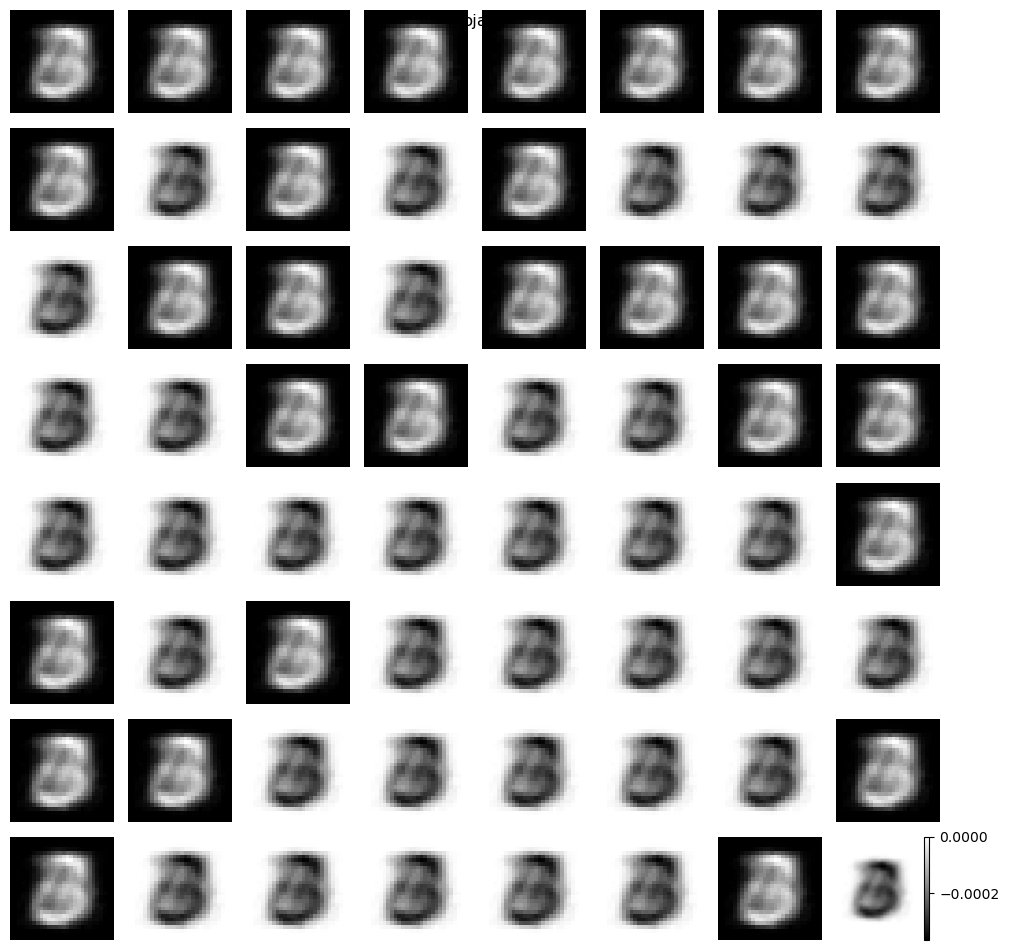

In [ ]:
### Variant 4.1: Oja's rule 

hidden_units = 64
mode = "normal"
rule = "oja" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
oja = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(oja, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("oja",oja.W)

In [ ]:
classify(oja)

Test accuracy (majority vote):     0.221
Test accuracy (linear classifier): 0.221


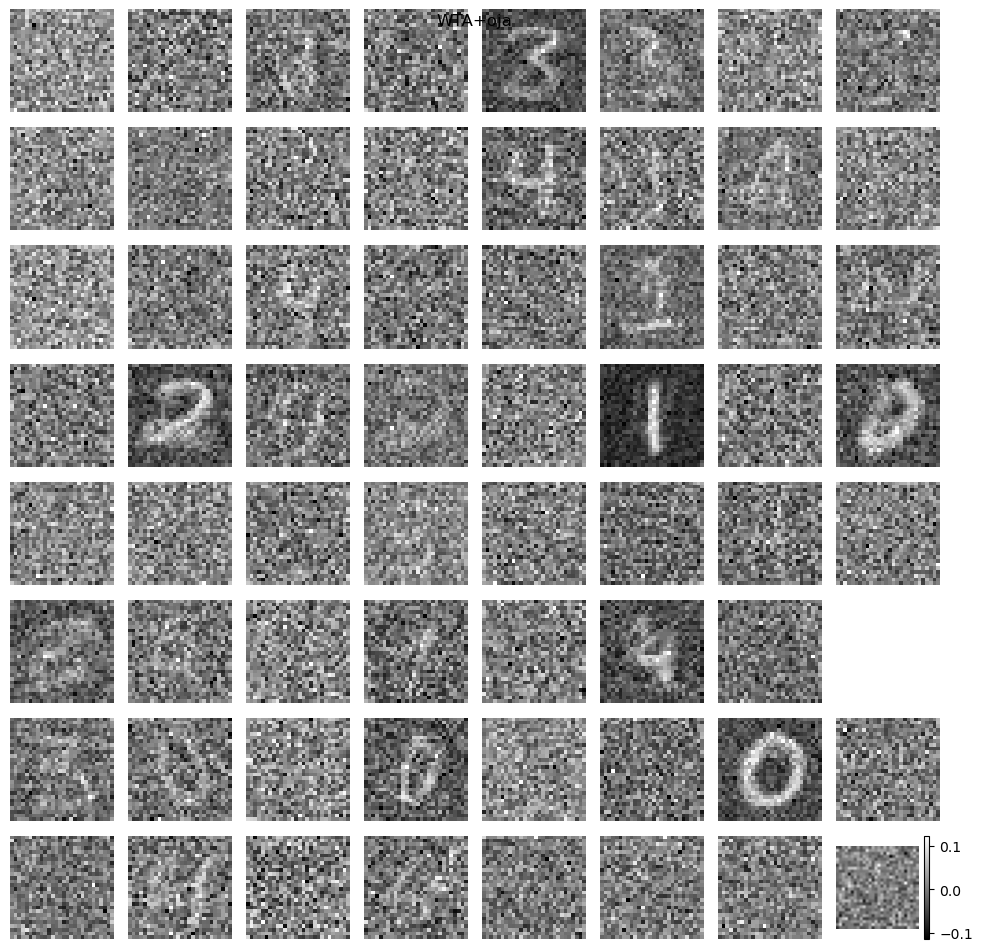

In [ ]:
### Variant 4.2: WTA + Oja's rule 

hidden_units = 64
mode = "WTA"
rule = "oja" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
WTAoja = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(WTAoja, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("WTA+oja",WTAoja.W)

In [ ]:
classify(WTAoja)

Test accuracy (majority vote):     0.221
Test accuracy (linear classifier): 0.193


In [ ]:
### Variant 4.2: WTA + Oja's rule 

hidden_units = 64
mode = "WTA"
rule = "BCM" # "hebb" and "oja", are your options here
norm_weights = False 

epochs = 20
eta = 0.05 # learning rate
batch_size = 128 # batch size

# input dim is just MNIST size.
WTAoja = HebbNet(input_dim=784, n_units=hidden_units, mode=mode, rule=rule, norm_weights=norm_weights)
train(WTAoja, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)

plot_weight_vectors("WTA+oja",WTAoja.W)

torch.Size([128, 64])


TypeError: mean() received an invalid combination of arguments - got (axis=int, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


## Results 

Variant 1: The weights for normal hebb did indeed just explode, as you can see I printed them and they all had nan values. Since I was curious what the shape of the weights would have looked like, I also tried the variant 1.2 hebb + weight normalization. The weights look all the same and "mushy" which I would say supports my assumption. 

Variant 2: For normal hebb in WTA there was not as much of an activation runaway snowball effect, as I had assumed. The weights seem to stay in a similar range (I tested for 5, 10, and 20 epoch). I am actually not sure why, since I thought WTA on its own does not have a regulation effect, just a competition. For the shapes of the weights, while they are quite pixelated, you can seem some shapes of numbers. When running for longer, i.e. 20 epochs, the weights get crispier for a few neurons but not all. That might be the snowball effect on the learning, i.e. if one neuron gets choosen over and over it "learns better". In an extreme case this might lead to mushy weights for one or a few neurons if they overwrite their learned patterns because they get chosen all the time. 


Variant 3: The weights look very similar to Variant 2, but sharper. The weight normalization probably helps stabilizing the learning. 

Variant 4: Oja's rule on its own has, as expected similar looking weights for every neuron. Since there is no competition on a neuron level, I would have expected the weights to become mushier. Oja + WTA does not look that differnt from WTA + normal hebbian learning. It seems like competition on a weights and a neuron level did not make a big difference here. 

Overall the best looking weights are achieved with WTA + normal hebb + weight normalization.

For the classification: I am not sure if I ran it correctly, since the accuracy stays pretty much the same for all models. Especially because hebb on its own has nan values as its weights and it achieved the same accuracy (~22%) as the rest. Maybe since this speficic dataset is quite tricky, the better looking weights didn't even make a difference. However, the variant that had the sharpest looking weights did have the best accuracy with 30.8%. 